### Demo to perform enrichment on GO terms

Here we can see the code to generate the enrichment with go terms

In [62]:
import json
import gzip
import copy
import re
import requests

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
from scipy.stats import fisher_exact
from wordcloud import WordCloud

### 1. Define basic datasets

After defining the GO datasets we are ready to create the other dataset (architetures, proteins and string).

In [68]:
RESULTS_PATH = 'data/results/jackhmmer.tsv' #Original dataset
GO_PATH = 'data/go/go.csv' # Dataset of all human protein with primal key (uniprot_id, go_id)

#Dataset of 'original' proteins with primal key (uniprot_id, go_id)
GO_ORIGINAL_PATH = OUT_PATH_GO_ORIGINAL = 'data/go/go_original.csv' 

In [69]:
# Load the results to see which uniprot proteins passed the model
original_dataset = pd.read_csv(RESULTS_PATH, sep='\t')
# Slice the GO dataset using the entry_ac of the protein that passed the model 
go_dataset = pd.read_csv(GO_PATH, sep='\t', dtype=str)
go_original_dataset = go_dataset[go_dataset.entry_ac.isin(original_dataset.entry_ac)]
# Save the model
go_original_dataset.to_csv(OUT_PATH_GO_ORIGINAL, sep='\t')
go_original_dataset.head()

,entry_ac,go_id,go_descr
5008,Q9BTA9,0016607,nuclear speck
5009,Q9BTA9,0005654,nucleoplasm
5010,Q9BTA9,0005634,nucleus
5011,Q9BTA9,0005681,spliceosomal complex
5012,Q9BTA9,0003682,chromatin binding


### 2. Define PDB datasets

Here we create the original and background datasets for PDB based on the GO dataset created in 1. <br>

It requires the file that maps a PDB_ID to a UNIPROT_ID

In [4]:
### REQUIRES
RESULTS_PATH = 'data/results/ensemble.tsv'
GO_PATH = 'data/go/go.csv'
MAPPING_FILE_PATH = 'data/pdb_data/pdb_chain_uniprot.tsv'
HUMAN_UNIPROT_PATH = 'data/human.csv'

OUT_BACKGROUND_PDB_PATH = 'data/pdb_data/pdb_background_go.csv'
OUT_TARGET_PDB_DATASETS_PATH = 'data/pdb_data/pdb_target_go.csv'

In [5]:
"""
Functions that create the datasets (target and background) for PDB network
"""
def pdb_target_dataset(original_dataset_path, go_dataset_path,
                       mapping_dataset_path, human_dataset_path,
                       col_name_entry = 'entry_ac', col_name_pdb = 'pdb_ids'):

    """
    1. original_dataset_path: the path of the target dataset, a.k.a the dataset of protein tha passed our model
    2. go_dataset_path: the path of the full go dataset (entry_ac, go_id)
    3. mapping_dataset_path: the path of the file mapping from pdb to uniprot
    4. human_dataset_path: the path of the full human dataset
    5. col_name_entry: the name of the column containing the proteins uniprot id
    6. col_name_pdb: the name of the column containing the proteins pdb id
    """

    ### 1. Load the mapping
    mapping_df = pd.read_table(mapping_dataset_path, header=1)
    mapping_df.columns = [col.lower() for col in mapping_df.columns]
    ### 2. Load the original dataset
    original_df = pd.read_table(original_dataset_path)
    ### 3. Load the go dataset
    background_df = pd.read_table(go_dataset_path, dtype={'entry_ac': str, 'go_id': str, 'go_descr': str})
    ### 4. Load the human dataset
    human_df = pd.read_table(human_dataset_path)
    # 4.1 Take out the entry_ac that have a pdb_id
    protein_with_pdb = human_df.entry_ac[human_df[col_name_pdb].isna() == False]
    # 4.2 Take out from  the background dataset the protein without a pdb
    background_df = background_df[background_df[col_name_entry].isin(protein_with_pdb)]
    ### 5. Get all original proteins with a pdb and get all the other proteins which shares the same pdb
    # 5.1. Get a dataset with key (uniprot_id, pdb_id)
    values = []
    for n in range(original_df.shape[1]):
        key = original_df.loc[n, col_name_entry]
        value = original_df.loc[n, col_name_pdb]
        if type(value) == str:
            pdb_ids = value.split(';')[:-1]
            for ids in pdb_ids:
                values.append([key, ids.lower()])
    pdb_original = pd.DataFrame(values, columns=[col_name_entry, col_name_pdb])
    # 5.2 Merge the new dataset with the mapping df to get all the proteins with that pdb id
    target_dataset = pd.merge(pdb_original, mapping_df, left_on=col_name_pdb, right_on='pdb', how='left')
    ### 6. Get the GO of every pdb_in our target_dataset
    target_dataset = background_df[background_df[col_name_entry].isin(target_dataset['sp_primary'])]
    ###

    return target_dataset, background_df

In [6]:
target_pdb, background_pdb = pdb_target_dataset(original_dataset_path=RESULTS_PATH, 
                                                go_dataset_path=GO_PATH, 
                                                mapping_dataset_path=MAPPING_FILE_PATH, 
                                                human_dataset_path=HUMAN_UNIPROT_PATH)

target_pdb.to_csv(OUT_TARGET_PDB_DATASETS_PATH, sep='\t')
background_pdb.to_csv(OUT_BACKGROUND_PDB_PATH, sep='\t')
target_pdb.head()

,entry_ac,go_id,go_descr
8713,Q9NZC7,0005737,cytoplasm
8714,Q9NZC7,0005829,cytosol
8715,Q9NZC7,0005794,Golgi apparatus
8716,Q9NZC7,0005739,mitochondrion
8717,Q9NZC7,0005654,nucleoplasm


### 3. Architecture Datasets

Here we create all the datasets divided by architectures

In [66]:
## REQUIRES 
HUMAN_UNIPROT_PATH = 'data/human.csv'
RESULTS_PATH = 'data/results/ensemble.tsv'
GO_PATH = 'data/go/go.csv'

OUT_BACKGROUND_ARCHITECTURE_PATH = 'data/architecture/go_architectures/architecture_background.csv'
OUT_TARGET_ARCHITECTURE_DATASETS_PATH = 'data/architecture/go_architectures/'

#### 3.1 We first create the background dataset (the original one) 

In [67]:
go_dataset = pd.read_csv(GO_PATH, sep='\t', dtype=str)
human_dataset = pd.read_csv(HUMAN_UNIPROT_PATH, sep='\t')
original_dataset = pd.read_csv(RESULTS_PATH, sep='\t')

# Select sets of domain families
architectures = [set(x.split(';')[:-1]) for x in original_dataset["pfam_ids"][original_dataset['pfam_ids'].isna() == False]]
# Sort architecture sets and convert them in strings
architectures = [';'.join(sorted(list(x))) for x in architectures]

# Create a new dataframe mapping each protein to its domain architecture
background_architecture = pd.DataFrame(list(zip(original_dataset['entry_ac'], architectures)), 
                                       columns=('entry_ac', 'architecture'), dtype=str)
# Save the dataframe
background_architecture = pd.merge(go_dataset, background_architecture)
background_architecture.to_csv(OUT_BACKGROUND_ARCHITECTURE_PATH, sep='\t')
background_architecture.head()

,entry_ac,go_id,go_descr,architecture
0,Q9BTA9,0016607,nuclear speck,PF00397
1,Q9BTA9,0005654,nucleoplasm,PF00397
2,Q9BTA9,0005634,nucleus,PF00397
3,Q9BTA9,0005681,spliceosomal complex,PF00397
4,Q9BTA9,0003682,chromatin binding,PF00397


#### 3.2) Secondly, we create all the target datasets (splitted by architecture sequence) 

In [9]:
"""
Function that extract the proteins belonging to a certain architecture and maps each protein to its
GO annotation. Accept in input the architecture of interest and two dataframes. The first one maps e
very protein to its architecture and requires columns 'entry_ac' and 'architecture', the second one
requires columns 'entry_ac' and 'go'.
"""
def select_architecture(arch, arch_df, go_df):
    assert arch in arch_df.architecture.values, 'Architecture not found'
    assert set(arch_df.entry_ac).issubset(set(go_df.entry_ac)), 'Architecture entries do not match'

    # 1. Select proteins that present the input architecture
    entries = arch_df.entry_ac[arch_df.architecture == arch]
    # 2. Retrieve GO for each protein
    return go_df.loc[go_df.entry_ac.isin(entries)]



"""
Loops over the architectures observed in 'original_arch' and apply 'select_architecture' to
each of them saving the outputs in BASE_PATH folder.
"""
# Load file that maps each protein to its architecture
original_arch = pd.read_csv(OUT_BACKGROUND_ARCHITECTURE_PATH, sep='\t', index_col=0)
# Load file that maps each protein to its GO annotations
ds_gene_ontology = pd.read_csv(GO_PATH, sep='\t', dtype=str)

# List all the observed architectures
arch_list = list(set(original_arch.architecture))

# Save tsv files for each architecture
for arch in arch_list:
    go_arch_df = select_architecture(arch=arch, arch_df=original_arch, go_df=ds_gene_ontology)
    go_arch_df.to_csv(OUT_TARGET_ARCHITECTURE_DATASETS_PATH+arch+'_arch.csv', sep='\t')
    
# Print last target architecture_dataset
go_arch_df.head()

,entry_ac,go_id,go_descr
83096,Q6ZUM4,0005737,cytoplasm
83097,Q6ZUM4,0016020,membrane
83098,Q6ZUM4,0005096,GTPase activator activity
83099,Q6ZUM4,0017124,SH3 domain binding
83100,Q6ZUM4,0043547,positive regulation of GTPase activity


### 4. STRING Dataset (TODO)

In [21]:
### REQUIRES
HUMAN_UNIPROT_PATH = 'data/human.csv'
RESULTS_PATH = 'data/results/ensemble.tsv'
GO_PATH = 'data/go/go.csv'
STRING_GZ_PATH = 'data/string/string.txt.gz'  # String dataset

OUT_STRING_TARGET = 'data/string/string_target_go.csv'
OUT_STRING_BACKGROUND = r'data/string/string_background_go.csv' #If error 22 try take out the r

In [11]:
# Load human proteome dataset
human_proteome = pd.read_csv(HUMAN_UNIPROT_PATH, sep='\t')
# Remove proteins that do not have a string id
human_proteome = human_proteome[human_proteome.string_id.isna() == False]
# Format string id column
human_proteome.string_id = human_proteome.string_id.map(lambda x: str(x).replace(';', '').strip())
human_proteome.head()

,entry_ac,entry_name,protein_name,len,domains,go,pdb_ids,pfam_ids,string_id,cath_ids,PF00397
0,Q9Y263,PLAP_HUMAN,Phospholipase A-2-activating protein (PLA2P) (...,795,WD repeat PLAP family,cell [GO:0005623]; cell junction [GO:0030054];...,2K89;2K8A;2K8B;2K8C;3EBB;,PF09070;PF08324;PF00400;,9606.ENSP00000380460,1.10.150.410;1.25.10.10;2.130.10.10;,False
1,Q96RE7,NACC1_HUMAN,Nucleus accumbens-associated protein 1 (NAC-1)...,527,NaN,cell junction [GO:0030054]; cytoplasm [GO:0005...,3GA1;4U2N;,PF10523;PF00651;,9606.ENSP00000292431,NaN,False
2,O43312,MTSS1_HUMAN,Protein MTSS 1 (Metastasis suppressor YGL-1) (...,755,MTSS family,actin cytoskeleton [GO:0015629]; cytoplasm [GO...,2D1K;,PF08397;PF02205;,9606.ENSP00000322804,1.20.1270.60;,False
3,Q9NP80,PLPL8_HUMAN,Calcium-independent phospholipase A2-gamma (EC...,782,NaN,endoplasmic reticulum membrane [GO:0005789]; G...,NaN,PF01734;,9606.ENSP00000410804,NaN,False
4,Q15319,PO4F3_HUMAN,"POU domain, class 4, transcription factor 3 (B...",338,"POU transcription factor family, Class-4 subfa...",cytoplasm [GO:0005737]; nuclear chromatin [GO:...,NaN,PF00046;PF00157;,9606.ENSP00000230732,1.10.260.40;,False


In [58]:
# Load original dataset
original = pd.read_csv(RESULTS_PATH, sep='\t')
original

,entry_ac,entry_name,protein_name,len,domains,go,pdb_ids,pfam_ids,string_id,cath_ids,PF00397
0,Q9BTA9,WAC_HUMAN,WW domain-containing adapter protein with coil...,647,NaN,nuclear speck [GO:0016607]; nucleoplasm [GO:00...,NaN,PF00397;,9606.ENSP00000346986;,NaN,True
1,Q9NZC7,WWOX_HUMAN,WW domain-containing oxidoreductase (EC 1.1.1....,414,Short-chain dehydrogenases/reductases (SDR) fa...,cytoplasm [GO:0005737]; cytosol [GO:0005829]; ...,1WMV;,PF00106;PF00397;,9606.ENSP00000457230;,NaN,True
2,Q9GZV5,WWTR1_HUMAN,WW domain-containing transcription regulator p...,400,NaN,cytoplasm [GO:0005737]; cytosol [GO:0005829]; ...,5N5R;5N5T;5N5W;5N75;,PF00397;,9606.ENSP00000419465;,NaN,True
3,Q8N3X1,FNBP4_HUMAN,Formin-binding protein 4 (Formin-binding prote...,1017,NaN,nuclear speck [GO:0016607],NaN,PF00397;,9606.ENSP00000263773;,NaN,True
4,O15428,PINL_HUMAN,Putative PIN1-like protein (Peptidylprolyl cis...,100,NaN,cytosol [GO:0005829]; nucleus [GO:0005634]; pe...,NaN,PF00397;,NaN,NaN,True
5,Q6IQ23,PKHA7_HUMAN,Pleckstrin homology domain-containing family A...,1121,NaN,cell junction [GO:0030054]; centrosome [GO:000...,NaN,PF00169;,9606.ENSP00000347883;,2.30.29.30;,False
6,Q6AWC2,WWC2_HUMAN,Protein WWC2 (BH-3-only member B) (WW domain-c...,1192,WWC family,cytosol [GO:0005829]; kinase binding [GO:00199...,NaN,PF00397;,9606.ENSP00000384222;,2.60.40.150;,True
7,Q9HCE7,SMUF1_HUMAN,E3 ubiquitin-protein ligase SMURF1 (hSMURF1) (...,757,NaN,axon [GO:0030424]; cell [GO:0005623]; cytoplas...,2LAZ;2LB0;2LB1;2LTX;3PYC;,PF00168;PF00632;PF00397;,9606.ENSP00000354621;,2.60.40.150;,True
8,Q9BYW2,SETD2_HUMAN,Histone-lysine N-methyltransferase SETD2 (EC 2...,2564,Class V-like SAM-binding methyltransferase sup...,chromosome [GO:0005694]; nucleoplasm [GO:00056...,2A7O;2MDC;2MDI;2MDJ;4FMU;4H12;5JJY;5JLB;5JLE;5...,PF17907;PF00856;PF08236;PF00397;,9606.ENSP00000386759;,1.10.1740.100;1.20.930.10;,True
9,Q9HAU0,PKHA5_HUMAN,Pleckstrin homology domain-containing family A...,1116,NaN,cytosol [GO:0005829]; glutamatergic synapse [G...,2DKP;,PF00169;PF00397;,9606.ENSP00000404296;,2.30.29.30;,True


In [13]:
# Load gene ontology dataset
gene_ontology = pd.read_csv(GO_PATH, sep='\t', dtype={
    'entry_ac': np.unicode_,
    'go_id': np.unicode_,
    'go_descr': np.unicode_
})
gene_ontology.head()

,entry_ac,go_id,go_descr
0,Q9Y263,0005623,cell
1,Q9Y263,0030054,cell junction
2,Q9Y263,0005737,cytoplasm
3,Q9Y263,0070062,extracellular exosome
4,Q9Y263,0005634,nucleus


In [14]:
def load(path, keep=None, sep=' '):
    # Load dataset
    string_ds = pd.read_csv('data/string.txt.gz', compression='gzip', header=0, sep=sep)
    # Subset pandas dataframe: keep only some rows
    if keep is not None:
        string_ds = string_ds[string_ds.protein1.isin(keep) | string_ds.protein2.isin(keep)]
    # Return retrieved dataset
    return string_ds



# Load interactions in human proteome
interactions = load(STRING_GZ_PATH)
protein_number = len(set(interactions.protein1.values))
print('Number of proteins: {}'.format(protein_number))
print('Mean number of interactions: {}'.format(interactions.shape[0]/protein_number))
interactions.head()

Number of proteins: 19354
Mean number of interactions: 607.5981192518342


,protein1,protein2,combined_score
0,9606.ENSP00000000233,9606.ENSP00000272298,490
1,9606.ENSP00000000233,9606.ENSP00000253401,198
2,9606.ENSP00000000233,9606.ENSP00000401445,159
3,9606.ENSP00000000233,9606.ENSP00000418915,606
4,9606.ENSP00000000233,9606.ENSP00000327801,167


In [15]:
# Define set of ids in original proteome (must be kept)
original_string_ids = set([i[:-1] for i in original.string_id.tolist() if type(i) == str])
# Get direct interactors
original_interaction = interactions[interactions.protein1.isin(original_string_ids)]
# Filter by score
original_interaction = original_interaction[original_interaction.combined_score > 700]
# Display
number_original_proteins = len(set(original_interaction.protein1.values))
number_of_interactors = len(set(original_interaction.protein2.values))
print('Number of protein 1: {}'.format(number_original_proteins))
print('Number of protein 2: {}'.format(number_of_interactors))
print('Mean number of interarctions: {}'.format(original_interaction.shape[0]/number_original_proteins))
original_interaction.head()

Number of protein 1: 44
Number of protein 2: 1483
Mean number of interarctions: 91.88636363636364


,protein1,protein2,combined_score
359354,9606.ENSP00000218224,9606.ENSP00000377969,908
359356,9606.ENSP00000218224,9606.ENSP00000356541,904
359365,9606.ENSP00000218224,9606.ENSP00000434359,907
359369,9606.ENSP00000218224,9606.ENSP00000225792,903
359370,9606.ENSP00000218224,9606.ENSP00000325376,951


In [47]:
# Define interactors ids
interactors_string_ids = set(original_interaction.protein2.tolist())
# Define union of the two sets
all_string_ids = original_string_ids | interactors_string_ids

# Get all proteins in original dataset, plus direct interactors
original = human_proteome[human_proteome.string_id.isin(all_string_ids)]
print('Number of orginal proteins: {}'.format(original.shape[0]))
original.head(1000)

Number of orginal proteins: 1477


,entry_ac,entry_name,protein_name,len,domains,go,pdb_ids,pfam_ids,string_id,cath_ids,PF00397
5,P08134,RHOC_HUMAN,Rho-related GTP-binding protein RhoC (Rho cDNA...,193,"Small GTPase superfamily, Rho family",cell cortex [GO:0005938]; cell division site [...,1Z2C;2GCN;2GCO;2GCP;,PF00071;,9606.ENSP00000285735,NaN,False
11,P51149,RAB7A_HUMAN,Ras-related protein Rab-7a,207,"Small GTPase superfamily, Rab family",autophagosome membrane [GO:0000421]; cell [GO:...,1T91;1YHN;3LAW;6IYB;,PF00071;,9606.ENSP00000265062,NaN,False
20,Q9GZS3,WDR61_HUMAN,WD repeat-containing protein 61 (Meiotic recom...,305,NaN,Cdc73/Paf1 complex [GO:0016593]; cytoplasm [GO...,3OW8;6GMH;,PF00400;,9606.ENSP00000267973,2.130.10.10;,False
64,O15273,TELT_HUMAN,Telethonin (Titin cap protein),167,NaN,cytosol [GO:0005829]; I band [GO:0031674]; Z d...,1YA5;2F8V;,PF09470;,9606.ENSP00000312624,2.20.160.10;,False
80,P11441,UBL4A_HUMAN,Ubiquitin-like protein 4A (Ubiquitin-like prot...,157,NaN,BAT3 complex [GO:0071818]; cytoplasm [GO:00057...,2DZI;4WWR;4X86;,PF17840;PF00240;,9606.ENSP00000358674,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...
13428,O15230,LAMA5_HUMAN,Laminin subunit alpha-5 (Laminin-10 subunit al...,3695,NaN,basement membrane [GO:0005604]; collagen-conta...,5XAU;,PF00052;PF00053;PF02210;PF06008;PF06009;PF00055;,9606.ENSP00000252999,2.60.120.1490;,False
13454,Q13200,PSMD2_HUMAN,26S proteasome non-ATPase regulatory subunit 2...,908,Proteasome subunit S2 family,cytosol [GO:0005829]; extracellular exosome [G...,5GJQ;5GJR;5L4K;5LN3;5T0C;5T0G;5T0H;5T0I;5T0J;5...,PF01851;PF18051;PF17781;,9606.ENSP00000310129,1.25.10.10;,False
13459,P10244,MYBB_HUMAN,Myb-related protein B (B-Myb) (Myb-like protei...,700,NaN,Myb complex [GO:0031523]; nucleoplasm [GO:0005...,6C48;,PF09316;PF00249;,9606.ENSP00000217026,NaN,False
13461,Q96QE2,MYCT_HUMAN,Proton myo-inositol cotransporter (H(+)-myo-in...,648,"Major facilitator superfamily, Sugar transport...",integral component of plasma membrane [GO:0005...,NaN,PF00083;,9606.ENSP00000280871,NaN,False


In [22]:
# String target GO dataset
string_target_go = gene_ontology[gene_ontology.entry_ac.isin(original.entry_ac)]
string_target_go.to_csv(OUT_STRING_TARGET, sep='\t')

# String background GO dataset
string_background_go = gene_ontology[gene_ontology.entry_ac.isin(human_proteome.entry_ac)]
string_background_go.to_csv(OUT_STRING_BACKGROUND, sep='\t')

### 5. ENRICHMENT

Here we perform enrichment on the different datasets

In [23]:
### REQUIRES
GO_ONTOLOGY_PATH = 'data/go/go.json.gz'

#### 5.1) Define helping functions

In [24]:
import warnings
warnings.filterwarnings("ignore")

"""
Perform Fisher test. An Odd-Ratio above 77 tells us the GO prefers the first dataframe (p-value < 0.05),
while an Odd-Ratio under 0.013 tells us the GO prefers the second dataframe.
Return a Dataframe with index the GO and values the Odd-Ratio and the p-value.
"""
def fisher_test(df1, df2, col_name_go = 'go_id'):

        # Inint dict
        results = {}

        # Get the number of occurrances of the GO counts
        dict1, dict2 = dict(df1[col_name_go].value_counts()), dict(df2[col_name_go].value_counts())

        # Compute the intersaction of the GO terms
        key_intersection = set(dict1.keys()).intersection(set(dict2.keys()))

        for key in tqdm(key_intersection, ncols=100,
                        bar_format='{l_bar}{bar:40}{r_bar}{bar:-40b}',
                        desc='Fisher Test      '):
        ### 1. Set frequencies
        # Number of occurrences of the specific GO term in DF1
            tp = dict1[key]
            # Number of occurrences of the specific GO term in DF2
            tn = dict2[key]
            # Number of GO terms that are different from the specific one in DF1
            fp = sum(dict1.values()) - tp
            # Number of GO terms that are different from the specific one in DF2
            fn = sum(dict2.values()) - tn
            # 2. Perform Fisher Exact Test
            fisher_results = fisher_exact([[tp, tn],[fp, fn]])
            # 3. Save results
            results.setdefault(key, {'OddRatio': fisher_results[0], 'p-value': fisher_results[1]})

        # Return the DataFrame
        return pd.DataFrame(results).transpose()

"""
To retrieve the GO that are parents, we cycle over ontology["graphs"][0]["edges"] which is a list of dictionary.
Every dictionary is about a GO id (sub) with a relation (pred) with another GO (obj).
We create a dictionary (parents) with as keys the sons and as values the parents.
"""
def get_parents(ontology):
    parents = {}  # {GO_id(son) : list of GO_id (parents)}
    for edge in ontology["graphs"][0]["edges"]:
        # select only is_a edges
        if edge["pred"] == "is_a":
            parents.setdefault(edge["sub"].split("_")[1], []).append(edge["obj"].split("_")[1])
    return parents

"""
Here we cycle over the nodes to obtain a dictionary of GO_id with as value a description.
- ontology["graphs"][0]["nodes"] is a list of dictionary with dict_keys(['id', 'meta', 'type', 'lbl'])
- ontology["graphs"][0]["nodes"][1]['lbl'] is the value (e.g: "endocytosed synaptic vesicle processing via endosome")
"""
def get_labels(ontology):
    labels = {}  # {term (GO_id): definition}
    for node in ontology["graphs"][0]["nodes"]:
        # exclude obsolete terms
        if "GO_" in node["id"] and "deprecated" not in node["meta"]:
            go_id = node["id"].split("_")[1]
            labels[go_id] = node["lbl"]
    return labels

"""
Build an ancestors dictionary with as key an GO_id and as value a list of GO_id which are the ancestors of the key.
Return ancestors = {GO_id : list of ancestor GO_ids}
"""
def get_ancestors(ontology):
    nodes = get_labels(ontology).keys()
    parents = get_parents(ontology)
    ancestors = {}
    for node in nodes:
        node_ancestors = []
        node_parents = parents.get(node)
        # Loop parent levels until no more parents
        while node_parents:
            node_ancestors.extend(node_parents)
            # Get the parents of current parents (1 level up)
            node_parents = [term for parent in node_parents for term in parents.get(parent, [])]
        ancestors[node] = node_ancestors
    return ancestors

"""
Build a dictionary for the children (similar to the ancestors one)
Return {node : list_of_children}, leaf terms are not keys.
"""
def get_children(ontology):
    ancestors = get_ancestors(ontology)
    children = {}
    for node in ancestors:
        for ancestor in ancestors[node]:
            children.setdefault(ancestor, set()).add(node)
    return children

"""
Calculate the minimum depth (distance from the closest root) of each term
"""
def get_depth(ontology):
    # Identify nodes with no predecessors
    nodes, parents = get_labels(ontology).keys(), get_parents(ontology)
    roots = set(nodes) - set(parents.keys())
    # Init the dictionary
    depth = {}
    for node in tqdm(nodes, ncols=100,
                     bar_format='{l_bar}{bar:40}{r_bar}{bar:-40b}',
                     desc='Depth            '):
        c = 0
        # Get parents of the node, return None if node is a root
        node_parents = parents.get(node)
        while node_parents:
            c += 1
            # Break the loop if the root is among parents
            if roots.intersection(set(node_parents)):
                break
            # Get the parents of current parents (1 level up)
            node_parents = [term for parent in node_parents for term in parents.get(parent, [])]
        depth[node] = c
    return depth

"""
Pipeline for the enrichment test. Take as input two dataframe and the onotlogy file.
Return a Dataframe with as index the GO_ids and values:
1. the p-value and Odd-Ration of the Fisher exact test,
2. the depth computed from the ontology file
3. the description of the GO_ids
"""
def enrich(df1, df2, ontology, col_name_go = 'go_id', col_name_descr='go_descr'):
    # 1. Get Fisher results
    df = fisher_test(df1, df2, col_name_go=col_name_go)
    # 2. Get Depth
    depth = get_depth(ontology)
    # 3. Get description
    labels = get_labels(ontology)
    # 4. Update dataframe
    labels_, depth_ , go_found= [], [], []
    for go_id in df.index:
        if depth.get(go_id):
            go_found.append(go_id)
            labels_.append(labels[go_id])
            depth_.append(depth[go_id])
    
    df = df[df.index.isin(go_found)]
    df['depth'] = depth_
    df[col_name_descr] = labels_
    # 5. Assign to every GO term the minimum pvalue between its pvalue and its children ones
    df = transmit_pvalue(df, ontology)
    # 6. Return dataframe
    return df

"""
Function that assign to every GO terms the minimum p-value between its own p-value and the p-values of their children.
"""
def transmit_pvalue(enrichment, ontology):
    # 1. Get the children of every GO term
    children_dict = get_children(ontology)
    # 2. For every GO in our enrichment dataset we assign to it the minimum p-value of its children
    for go_id in tqdm(enrichment.index, ncols=100,
                      bar_format='{l_bar}{bar:40}{r_bar}{bar:-40b}',
                      desc='Propagate p-value'):
        # Check if the GO term has child
        if children_dict.get(go_id):
            # Retrieve the set of the p-values of all its children
            pvalues = enrichment['p-value'][enrichment.index.isin(children_dict[go_id])]
            # Check we have some children in the dataset. Otherwise we have an empy set 'pvalues'
            if list(pvalues.values):
                # Check if the mimimum pvalue is actually lower than the ancestor one
                min_pvalue = pvalues.min()
                if min_pvalue < enrichment['p-value'][enrichment.index == go_id].values[0]:
                    # If all the conditions are True we assign the minimum pvalue
                    enrichment['p-value'][enrichment.index == go_id] = min_pvalue
    return enrichment

"""
Filter the enrich dataframe by taking out GO_terms with high p-value or high depth
"""
def enrich_filter(df, max_pvalue=0.05, max_depth=5):
    df_filter = df[(df['p-value'] < max_pvalue) & (df['depth'] < max_depth)]
    df_filter['score'] = np.log(1/df['p-value'])
    return df_filter

"""
Create the word cloud of the description of the enriched dataframe, using as frequencies the inverse of p-value
"""
def word_cloud(df, col_name, col_score, *args, **kwargs):
    return WordCloud(*args, **kwargs).generate_from_frequencies({
        row[col_name]: row[col_score] for i, row in df.iterrows()
    })

In [25]:
def enrichment_pipeline(GO_ONTOLOGY_PATH, TARGET_PATH, BACKGROUND_PATH, max_depth, max_pvalue):
    # 3. Load the required files
    with gzip.open(GO_ONTOLOGY_PATH) as f:
        ontology = json.load(f)

    ### DF1 and DF2
    original_go= pd.read_table(TARGET_PATH,
                               dtype={'entry_ac': str,
                                      col_name_go_id: str,
                                      col_name_descr: str})

    background_go= pd.read_table(BACKGROUND_PATH,
                                 dtype={'entry_ac': str,
                                        col_name_go_id: str,
                                        col_name_descr: str})

    # 3. Compute the enrichness
    enrich_result = enrich(df1=original_go,
                           df2=background_go,
                           ontology=ontology,
                           col_name_descr=col_name_descr,
                           col_name_go=col_name_go_id)

    # 4. Filter the results and create the WordCloud
    ### Results
    enrich_result = enrich_filter(df = enrich_result, max_depth=max_depth, max_pvalue=max_pvalue)
    ### WordCloud.
    wc = word_cloud(df=enrich_result, col_name=col_name_descr, col_score='score')

    return enrich_result, wc 

#### 5.2) Enrichment: Original vs Human

Perform enrichment of first dataset. Output results are not saved, just displayed

Fisher Test      : 100%|████████████████████████████████████████| 581/581 [00:14<00:00, 39.30it/s]  
Depth            : 100%|████████████████████████████████████████| 44650/44650 [00:00<00:00, 45472.84
Propagate p-value: 100%|████████████████████████████████████████| 581/581 [00:01<00:00, 381.52it/s] 


,OddRatio,p-value,depth,go_descr,score
1904047,0.041567,0.044294,3,S-adenosyl-L-methionine binding,3.116914
0048037,0.071800,0.044294,2,cofactor binding,3.116914
0050662,0.041567,0.044294,3,coenzyme binding,3.116914
0008134,0.322527,0.043044,3,transcription factor binding,3.145541
0101031,0.037788,0.040679,2,chaperone complex,3.202053


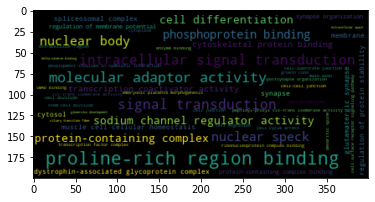

In [26]:
### REQUIRES
GO_ONTOLOGY_PATH = 'data/go/go.json.gz'
TARGET_PATH = 'data/go/go.csv' # Dataset of all human protein with primal key (uniprot_id, go_id)
BACKGROUND_PATH = 'data/go/go_original.csv' #Dataset of 'original' proteins with primal key (uniprot_id, go_id)

### Params
col_name_go_id = 'go_id'
col_name_descr = 'go_descr'
max_pvalue = 0.05
max_depth = 4

### Pipeline
results, word_cloud_img = enrichment_pipeline(GO_ONTOLOGY_PATH=GO_ONTOLOGY_PATH, 
                                              TARGET_PATH=TARGET_PATH, 
                                              BACKGROUND_PATH=BACKGROUND_PATH, 
                                              max_pvalue=max_pvalue,
                                              max_depth=max_depth)

### Display results
fig = plt.imshow(word_cloud_img, interpolation='bilinear')
results.sort_values(by='score').head()

#### 5.3) Enrichment: Original with PDB + other with same PDB vs Huamn with PDB

Fisher Test      : 100%|████████████████████████████████████████| 313/313 [00:01<00:00, 220.40it/s] 
Depth            : 100%|████████████████████████████████████████| 44650/44650 [00:00<00:00, 44672.54
Propagate p-value: 100%|████████████████████████████████████████| 313/313 [00:00<00:00, 669.12it/s] 


,OddRatio,p-value,depth,go_descr,score
0009880,25.886203,0.040779,3,embryonic pattern specification,3.199587
0007596,6.482405,0.039978,3,blood coagulation,3.219435
0048037,24.037025,0.029300,2,cofactor binding,3.530161
0050662,37.392202,0.029300,3,coenzyme binding,3.530161
0031386,42.066514,0.026409,1,protein tag,3.634045


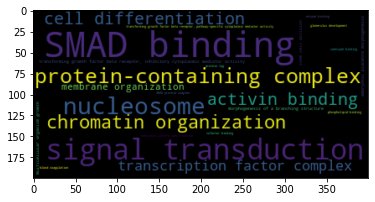

In [27]:
### REQUIRES
GO_ONTOLOGY_PATH = 'data/go/go.json.gz'
TARGET_PATH = 'data/pdb_data/pdb_target_go.csv' 
BACKGROUND_PATH = 'data/pdb_data/pdb_background_go.csv'

### Params
col_name_go_id = 'go_id'
col_name_descr = 'go_descr'
max_pvalue = 0.05
max_depth = 4
+

### Pipeline
results, word_cloud_img = enrichment_pipeline(GO_ONTOLOGY_PATH=GO_ONTOLOGY_PATH, 
                                              TARGET_PATH=TARGET_PATH, 
                                              BACKGROUND_PATH=BACKGROUND_PATH, 
                                              max_pvalue=max_pvalue,
                                              max_depth=max_depth)

### Display results
fig = plt.imshow(word_cloud_img, interpolation='bilinear')
results.sort_values(by='score').head()

#### 5.4) Enrichment: One specific architecture vs All architecture

Fisher Test      : 100%|████████████████████████████████████████| 10/10 [00:00<00:00, 285.23it/s]   
Depth            : 100%|████████████████████████████████████████| 44650/44650 [00:00<00:00, 46013.50
Propagate p-value: 100%|████████████████████████████████████████| 10/10 [00:00<00:00, 1155.58it/s]  


,OddRatio,p-value,depth,go_descr,score
0005096,27.111111,0.049593,4,GTPase activator activity,3.003900
0043087,36.185185,0.039855,5,regulation of GTPase activity,3.222495
0043312,108.777778,0.020110,4,neutrophil degranulation,3.906533
0005576,108.777778,0.020110,2,extracellular region,3.906533


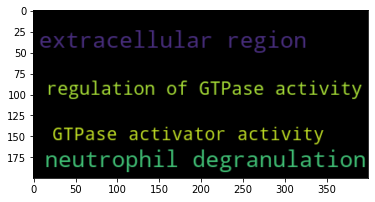

In [28]:
### REQUIRES
GO_ONTOLOGY_PATH = 'data/go/go.json.gz'
TARGET_PATH = 'data/architecture2/go_architectures/PF00018;PF00169;PF00620_arch.csv' 
BACKGROUND_PATH = 'data/architecture2/go_architectures/architecture_background.csv'

### Params
col_name_go_id = 'go_id'
col_name_descr = 'go_descr'
max_pvalue = 0.05
max_depth = 6

### Pipeline
results, word_cloud_img = enrichment_pipeline(GO_ONTOLOGY_PATH=GO_ONTOLOGY_PATH, 
                                              TARGET_PATH=TARGET_PATH, 
                                              BACKGROUND_PATH=BACKGROUND_PATH, 
                                              max_pvalue=max_pvalue,
                                              max_depth=max_depth)

### Display results
fig = plt.imshow(word_cloud_img, interpolation='bilinear')
results.sort_values(by='score').head()

#### 5.5) Enrichment: original plus STRING interactors with original dataset vs whole STRING dataset contained in SwissProt

Fisher Test      : 100%|████████████████████████████████████████| 6774/6774 [01:22<00:00, 82.26it/s]
Depth            : 100%|████████████████████████████████████████| 44650/44650 [00:00<00:00, 50423.74
Propagate p-value: 100%|████████████████████████████████████████| 6771/6771 [00:11<00:00, 576.76it/s


,OddRatio,p-value,depth,go_descr,score
0032496,0.540931,0.048964,4,response to lipopolysaccharide,3.016669
0007389,1.123132,0.048584,2,pattern specification process,3.024452
0009880,2.450739,0.048584,3,embryonic pattern specification,3.024452
0030326,1.728062,0.048378,5,embryonic limb morphogenesis,3.028708
0035137,3.369597,0.048378,5,hindlimb morphogenesis,3.028708


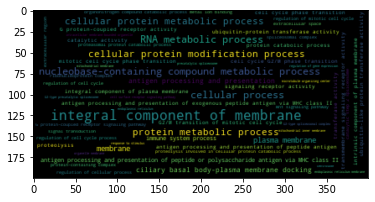

In [29]:
### REQUIRES
GO_ONTOLOGY_PATH = 'data/go/go.json.gz'
TARGET_PATH = 'data/string/string_target_go.csv' 
BACKGROUND_PATH = 'data/string/string_background_go.csv'

### Params
col_name_go_id = 'go_id'
col_name_descr = 'go_descr'
max_pvalue = 0.05
max_depth = 6

### Pipeline
results, word_cloud_img = enrichment_pipeline(GO_ONTOLOGY_PATH=GO_ONTOLOGY_PATH, 
                                              TARGET_PATH=TARGET_PATH, 
                                              BACKGROUND_PATH=BACKGROUND_PATH, 
                                              max_pvalue=max_pvalue,
                                              max_depth=max_depth)

### Display results
fig = plt.imshow(word_cloud_img, interpolation='bilinear')
results.sort_values(by='score').head()